<a href="https://colab.research.google.com/github/A-Alviento/mlda-deep-learning-week-hackathon/blob/main/spam_message_detector_nlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Library Imports**

In [ ]:
! pip list | grep gensim
! python --version

gensim                        3.6.0
Python 3.7.14


In [2]:
import numpy as np
import pandas as pd
import re
import nltk
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [3]:
# tokenizer used to tokenize data
from tensorflow.keras.preprocessing.text import Tokenizer
# pad sequence used to pad datasets which are not long enough, need to pad for constant len input
from tensorflow.keras.preprocessing.sequence import pad_sequences
# sequential model to feeding our model layers
from tensorflow.keras.models import Sequential
# layers
from tensorflow.keras.layers import Dense, Embedding, LSTM, Conv1D, MaxPool1D
# train test split is to split data sets into training set and test set
from sklearn.model_selection import train_test_split
# accuracy report and accuracy score used to test model performance
from sklearn.metrics import classification_report, accuracy_score

# **Reading in the dataset**

In [4]:
# read spam dataset into a frame data
data = pd.read_csv("https://raw.githubusercontent.com/A-Alviento/mlda-deep-learning-week-hackathon/main/data/spam.csv", encoding = "ISO-8859-1") 

In [5]:
# show first few lines of spam data set
data.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [6]:
# show column headings of the spam data set
data.columns

Index(['v1', 'v2', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], dtype='object')

In [7]:
# we can check how many types of "hams" and "spams"
data['v1'].value_counts()

ham     4825
spam     747
Name: v1, dtype: int64

In [8]:
# make two arrays, one to indicate spam and another to store the sms
spam_arr = data['v1'].tolist()
data_list = data['v2'].tolist()

# separate the data set into spam and ham
spam = []
ham = []

for i in range(len(spam_arr)):
  if spam_arr[i] == 'ham':
    ham.append(data_list[i])
  else:
    spam.append(data_list[i])

**Wordcloud (spam)**

In [9]:
# here we're going to use wordcloud to visualise text data

# however, we don't want a list for our text data. we want it to be a single text data
# what this code does is every list element is joined with a space
text = ' '.join(spam)

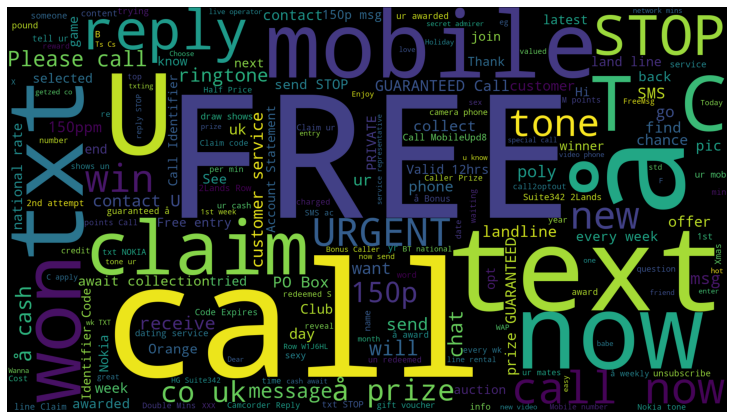

In [10]:
# now we can use wordcloud

wordcloud = WordCloud(width=1920, height=1080).generate(text)
# visualise the wordcloud
fig = plt.figure(figsize=(10,10))
plt.imshow(wordcloud)
# don't show axis
plt.axis('off')
# don't put padding
plt.tight_layout(pad=0)
plt.show()

In [ ]:
!mkdir -p data
wordcloud.to_file("./data/spam.png")

**Wordcloud (ham)**

In [11]:
# here we're going to use wordcloud to visualise text data

# however, we don't want a list for our text data. we want it to be a single text data
# what this code does is every list element is joined with a space
text = ' '.join(ham)

In [12]:
# now we can use wordcloud
wordcloud = WordCloud(width=1920, height=1080).generate(text)
wordcloud.to_file("./data/ham.png")
# visualise the wordcloud
fig = plt.figure(figsize=(10,10))
plt.imshow(wordcloud)
# don't show axis
plt.axis('off')
# don't put padding
plt.tight_layout(pad=0)
plt.show()

FileNotFoundError: ignored

In [ ]:
!mkdir -p data
wordcloud.to_file("./data/ham.png")

# **Cleaning Data Set**

In [ ]:
# show us random 5 sms
data.sample(5)

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
1415,ham,jay is snickering and tells me that x is total...,NaN,NaN,NaN
367,spam,here is your discount code rp176781. to stop f...,NaN,NaN,NaN
3472,ham,you getting back any time soon?,NaN,NaN,NaN
1173,ham,ìï dun need to pick ur gf?,NaN,NaN,NaN
391,ham,hey so this sat are we going for the intro pil...,NaN,NaN,NaN


In [ ]:
# show us shape of our dataset
data.shape

(5572, 5)

In [ ]:
# convert data set sms to lowercase
data['v2'] = data['v2'].apply(lambda x: str(x).lower())

In [ ]:
# we need to label the spam and the ham
list_of_cols_to_change = ['v1']
data["v1"] = data["v1"].apply(lambda x: 1 if x == "spam" else 0)
data

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,0,"go until jurong point, crazy.. available only ...",NaN,NaN,NaN
1,0,ok lar... joking wif u oni...,NaN,NaN,NaN
2,1,free entry in 2 a wkly comp to win fa cup fina...,NaN,NaN,NaN
3,0,u dun say so early hor... u c already then say...,NaN,NaN,NaN
4,0,"nah i don't think he goes to usf, he lives aro...",NaN,NaN,NaN
...,...,...,...,...,...
5567,1,this is the 2nd time we have tried 2 contact u...,NaN,NaN,NaN
5568,0,will ì_ b going to esplanade fr home?,NaN,NaN,NaN
5569,0,"pity, * was in mood for that. so...any other s...",NaN,NaN,NaN
5570,0,the guy did some bitching but i acted like i'd...,NaN,NaN,NaN


In [ ]:
# we only need v1 and v2, drop the rest
data = data[['v1', 'v2']]
data.sample(5)

,v1,v2
4352,0,fun fact: although you would think armand woul...
2113,0,"yeah, don't go to bed, i'll be back before mid..."
1485,0,(i should add that i don't really care and if ...
2234,0,what's your room number again? wanna make sure...
3787,1,want to funk up ur fone with a weekly new tone...


**Removing special characters** <br>
Used library https://github.com/laxmimerit/preprocess_kgptalkie.git

In [ ]:
!pip install spacy==2.2.3
!python -m spacy download en_core_web_sm
!pip install beautifulsoup4==4.9.1
!pip install textblob==-0.15.3
!pip install git+https://github.com/laxmimerit/preprocess_kgptalkie.git --upgrade --force-reinstall

In [ ]:
# remove special characters
import preprocess_kgptalkie as ps

data['v2'] = data['v2'].apply(lambda x: ps.remove_special_chars(x))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [ ]:
data.sample(5)

,v1,v2
797,0,petey boy whereare you me and all your friends...
1703,0,just taste fish curry p
4803,0,er hello things didnût quite go to plan ûò is ...
3329,0,send me yettys number pls
1863,0,ill let you know when it kicks in


# **Vectorisation**

In [ ]:
# we use vectorisation technique - word2vec to convert a word into a sequence of vectors
import gensim

In [ ]:
# get array of class
y = data['v1'].values
# data['v2'].tolist turns sms data into a sequence of list, which we need to convert into a list of words
x = [i.split() for i in data['v2'].tolist()]

In [ ]:
print(x[0])

['go', 'until', 'jurong', 'point,', 'crazy..', 'available', 'only', 'in', 'bugis', 'n', 'great', 'world', 'la', 'e', 'buffet...', 'cine', 'there', 'got', 'amore', 'wat...']


In [ ]:
!# each word is converted into a seq of 100 vectors
dim = 100
# creat a gensim model
# sentences are the list of the list, x, the size is dim, window shows us how many words are connected together, min_count means even if there is only 1 word it generates a vecor for that
w2v = gensim.models.Word2Vec(sentences=x, size=dim, window=10, min_count=1)

In [ ]:
# how many words are in w2v vocabulary after we vectorised x
len(w2v.wv.vocab)

13496

In [ ]:
# shows the vectors assigned to word 'singapore'
w2v.wv['singapore']

array([-4.6818592e-03, -1.1824628e-03, -8.5181807e-04, -4.4423048e-03,
        2.8590261e-04,  3.1587197e-03, -3.1650406e-03,  2.9744860e-03,
       -3.9043692e-03,  3.7610838e-03,  7.5597852e-04, -1.3472375e-03,
        3.0431820e-03, -3.0776791e-03, -2.6216705e-03, -8.7077642e-04,
       -7.0647686e-04,  6.0484861e-04,  7.1200433e-05, -2.2387139e-03,
       -4.5169163e-03,  1.3409272e-03,  9.7431103e-04,  2.1681050e-04,
       -7.7846448e-04,  5.3475839e-03,  4.1677798e-03,  3.5219947e-03,
        4.2564231e-03, -4.4172131e-03, -9.5041723e-05, -4.4619609e-03,
       -8.0018700e-04, -7.1984844e-04, -4.2896708e-03, -4.8489608e-03,
        1.2391433e-03, -5.0497260e-03,  9.5083460e-04,  3.9678853e-04,
        7.8644301e-04, -2.2474942e-03,  1.4418804e-03,  3.5735173e-03,
        4.2788964e-03, -2.2433510e-03,  4.1811261e-03, -2.2940394e-03,
        4.4732932e-03, -3.6221098e-03, -1.5985785e-04, -4.6401764e-03,
       -2.8041196e-03,  3.8992858e-03,  1.4550691e-03, -5.4715578e-03,
      

In [ ]:
# returns words most similar to 'singapore' based on vectorisation
w2v.wv.most_similar('singapore')

[('tootsie', 0.41549763083457947),
 ('patent.', 0.4031710624694824),
 ('god!', 0.3660658001899719),
 ('uk!', 0.36239826679229736),
 ('cancel,', 0.35545796155929565),
 ('vco', 0.3551144003868103),
 ('appropriate', 0.33639466762542725),
 ('fne', 0.33440208435058594),
 ('website..now', 0.33209216594696045),
 ('spelled', 0.3317393660545349)]

In [ ]:
# returns words most similar to 'hello' based on vectorisation
w2v.wv.most_similar('hello')

[('more', 0.9997432231903076),
 ('keep', 0.999732255935669),
 ('last', 0.9997318387031555),
 ('had', 0.9997280836105347),
 ('thing', 0.9997260570526123),
 ('as', 0.9997240304946899),
 ('it.', 0.9997235536575317),
 ('better', 0.9997206926345825),
 ('one', 0.9997203946113586),
 ('just', 0.9997199773788452)]

In [ ]:
# now our text is converted into vectors
# we can feed these vectors as initial weight in machine learning model, and then use the machine learning to recreate this weights again

# create tokenizer 
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x)

In [ ]:
import pickle

!mkdir -p data
pickle.dump(tokenizer, open("./data/tokenizer.pickle", "wb"), pickle.HIGHEST_PROTOCOL)

In [ ]:
# after tokenisation, text data is converted into a set of sequence
x = tokenizer.texts_to_sequences(x)

In [ ]:
# we get the word index using here
# for e.g. a number is assigned to any word
# for some text, we just substitute the word for the index based on this assignment
# note index of this starts from 1

# this list the assigned index to each word
tokenizer.word_index

{'to': 1,
 'i': 2,
 'you': 3,
 'a': 4,
 'the': 5,
 'u': 6,
 'and': 7,
 'is': 8,
 'in': 9,
 'my': 10,
 'for': 11,
 'your': 12,
 'of': 13,
 'me': 14,
 'have': 15,
 'call': 16,
 'on': 17,
 'are': 18,
 'that': 19,
 'it': 20,
 '2': 21,
 'so': 22,
 'but': 23,
 'or': 24,
 'not': 25,
 'at': 26,
 'can': 27,
 'ur': 28,
 'if': 29,
 'with': 30,
 "i'm": 31,
 'be': 32,
 'get': 33,
 'will': 34,
 'do': 35,
 'just': 36,
 'we': 37,
 'this': 38,
 'when': 39,
 'from': 40,
 '&lt;#&gt;': 41,
 'go': 42,
 'up': 43,
 'all': 44,
 'no': 45,
 'how': 46,
 'what': 47,
 '4': 48,
 'now': 49,
 '.': 50,
 'got': 51,
 'like': 52,
 'know': 53,
 'was': 54,
 'free': 55,
 'out': 56,
 'come': 57,
 'am': 58,
 'its': 59,
 'then': 60,
 'good': 61,
 '?': 62,
 'send': 63,
 'only': 64,
 'want': 65,
 'he': 66,
 'as': 67,
 'text': 68,
 'time': 69,
 "i'll": 70,
 'by': 71,
 '...': 72,
 'going': 73,
 'ok': 74,
 'love': 75,
 'about': 76,
 'need': 77,
 'r': 78,
 'still': 79,
 'txt': 80,
 'one': 81,
 'see': 82,
 'n': 83,
 'our': 84,
 'new'

In [ ]:
# get the length for every list in x, i.e. number of words in each article
[len(i) for i in x]

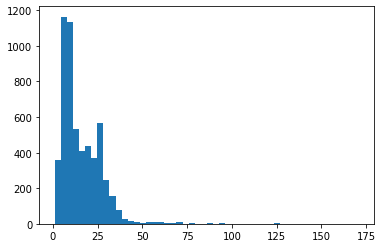

In [ ]:
# now we analyse our text data using a histogram
plt.hist([len(i) for i in x], bins = 50)
plt.show()

In [ ]:
# create array to indicate number of words for sms i
nos = np.array([len(i) for i in x])
# count numer of articles with word count > 100
len(nos[nos>100])

6

In [ ]:
# we create a threshold of word limit
maxlen = 100
# when sequence is more than 100, truncate, if less than 100 pad it
x = pad_sequences(x, maxlen=maxlen)

In [ ]:
# now len of any sequence is 1000
len(x[3])

100

In [ ]:
# we put +1 as there are many words that may not come in the tokens
# for those words, we consider those as unknown words which creates another sequence
vocab_len = len(tokenizer.word_index) + 1
# voc takes on the tokenizer.word_index which represents the word to index conversion
voc = tokenizer.word_index

In [ ]:
# feed vectors as the initial weight in the machine learning model and then we use the machine learning model to retrain this weight to find the maximum accuracy
def get_weight_matrix(model):
  # weight matrix for the words
  weight_matrix = np.zeros((vocab_len, dim))
  for word, i in voc.items():
    # assign the weight
    weight_matrix[i] = model.wv[word]

  return weight_matrix

In [ ]:
weight_matrix = get_weight_matrix(w2v)

In [ ]:
# gives us shape of the matrix
weight_matrix.shape

(13497, 100)

In [ ]:
# so all in all, the weight_matrix represents a weight_matrix
# i-th element is the array of dim-sized vectors assigned to the word with i-th index as tokenisation
# in this case, 1 represents the word 'the'
weight_matrix[1]

array([-1.10477936, -0.08390809,  0.75960952,  0.11470152,  0.30442554,
       -0.53068602,  0.1256014 ,  0.50206077, -0.86189437, -0.69815975,
       -0.81311786,  1.08158457, -2.36689973,  1.60599196,  1.62149107,
        1.33629966,  0.80211014,  1.90906346,  0.63001502, -1.41993225,
       -1.11521482, -0.32550642,  2.5143013 ,  2.29145074,  3.15244222,
        1.79303741,  2.51079822, -2.13957787,  0.96223617,  0.39582554,
        2.14323378, -0.22670299,  1.10349214,  0.65239525, -0.0273801 ,
       -1.22230065, -0.58078814, -0.86589521,  2.04133296, -0.26780549,
       -1.24163973, -2.00297689,  0.50699335, -0.77582079, -0.16308686,
        0.9228431 ,  0.74194831, -0.55513555,  2.99448299,  0.30160284,
       -1.07749689,  0.1783998 , -0.51579702, -0.29885972, -0.87900484,
       -0.89776802, -0.57298952, -0.86959213, -0.49021691, -1.12364292,
       -0.0926678 , -0.08235647, -0.57001758,  0.34004223,  2.16257977,
       -0.36076233,  0.27123967, -1.8967725 ,  0.78524125,  0.32

# **Simple Machine Learning Model**

Sequential model is one of two different approaches we can use in building our models in tensorflow.

Sequential model is good for simple sequential stacks of layers where each layers has one input, and one outpus.

Most models are made of layers, layers are functions with known mathematical structure that can be reused and have trainable variables.


In [ ]:
# here we create our machine learning model; we create an instance of the Sequential Class
model = Sequential()

# model layers are subsequently added to it

# here we add an embedding layer - first arg is number of distinct words in training set; second arg is size of embedding vector (dim of vectorisation); 
# third arg is just our array of weights for the words; fourth arg is the size of each input sequence; last arg indicates if we want our weight_matrix
# to be trainable, i.e. to adapt according to the machine learning
model.add(Embedding(vocab_len, output_dim=dim, weights = [weight_matrix], input_length=maxlen, trainable=True))

# here we add a long short-term memory layer. lstm is a special version of RNN which solves short term memory problem
# unit refers to the dimensionality of the output space, which is the dimension of the hidden state vector a that is the
# state output from RNN cell
model.add(LSTM(units=128))

# adding a dense layer. 
# first arg represents the number of units and it affects the output layer; second arg represents the activation function
# here we are using sigmoid as the activation function and it guarantees that the output of this unit will always be between 0 and 1
model.add(Dense(1, activation='sigmoid'))

# compile the model since we already defined it
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [ ]:
# summary of model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          1349700   
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1,467,077
Trainable params: 1,467,077
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# split data sets into training and testing sets
# recall x is the text and y is the class 
x_train, x_test, y_train, y_test = train_test_split(x,y)

# **Training**

In [ ]:
# training
model.fit(x_train, y_train, validation_split=0.3, epochs=6)

Epoch 1/6
92/92 [==============================] - 30s 289ms/step - loss: 0.2954 - acc: 0.8885 - val_loss: 0.2483 - val_acc: 0.8963
Epoch 2/6
92/92 [==============================] - 16s 179ms/step - loss: 0.1532 - acc: 0.9439 - val_loss: 0.0773 - val_acc: 0.9793
Epoch 3/6
92/92 [==============================] - 15s 164ms/step - loss: 0.0373 - acc: 0.9915 - val_loss: 0.0578 - val_acc: 0.9833
Epoch 4/6
92/92 [==============================] - 16s 169ms/step - loss: 0.0140 - acc: 0.9952 - val_loss: 0.0844 - val_acc: 0.9657
Epoch 5/6
92/92 [==============================] - 16s 177ms/step - loss: 0.0084 - acc: 0.9983 - val_loss: 0.0716 - val_acc: 0.9801
Epoch 6/6
92/92 [==============================] - 16s 170ms/step - loss: 0.0044 - acc: 0.9993 - val_loss: 0.0803 - val_acc: 0.9793


In [ ]:
# if model.predict(x_test) outputs a value above or equals to 0.5, we round up to 1, indicating that the model thinks article is real
prediction = (model.predict(x_test) >= 0.5).astype(int)

In [ ]:
# prints the accuracy when tested against dataset
accuracy_score(y_test, prediction)

0.9770279971284996

In [ ]:
!pip install anvil-uplink
import anvil.server
anvil.server.connect("GVZMFGWPXWS6CKHWUIICWWRB-DBT47VVXR4W3KP5W")

# **Real Test**

In [ ]:
# upload a md file of sms message
from google.colab import files
uploaded = files.upload()

Saving spam.md to spam.md


In [ ]:
# convert md file into array of a single string

import markdown
from bs4 import BeautifulSoup
html = markdown.markdown(open("spam.md").read())
test = "".join(BeautifulSoup(html).findAll(text=True))

test1 = ""
for c in test:
  if (c.isalpha() or c==" "):
    test1+=c
  else:
    test1+=" "

test1 = test1.lower()
x = [test1]
x

['free entry in   a wkly comp to win fa cup final tkts   st may       text fa to       to receive entry question std txt rate t c s apply            over   s']

In [ ]:
#@title
y = "o until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat..." #@param {type:"string"}
x = [y]

In [ ]:
# convert x into "testable" type

x = tokenizer.texts_to_sequences(x)
x = pad_sequences(x, maxlen=maxlen)
x

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0, 1060,  393, 5508, 1028,  965,  709,   64,    9,
        1709,   83,  131,  440, 3440,  139, 6017, 1488,   86,   51, 5512,
         184]], dtype=int32)

In [ ]:
# gives prediction 
# 1 is spam, 0 is ham
model.predict(x)

array([[0.00025195]], dtype=float32)

In [ ]:
!mkdir -p "./data/"
model.save("./data/model.h5")

# **Anvil Server (Not used)**

In [ ]:
@anvil.server.callable
def main(x):
  test1 = ""
  for c in x:
    if (c.isalpha() or c==" "):
      test1+=c
    else:
      test1+=" "

  test1 = test1.lower()
  x = [test1]

  x = tokenizer.texts_to_sequences(x)
  x = pad_sequences(x, maxlen=maxlen)
  prediction = model.predict(x)
  return prediction

In [ ]:
anvil.server.wait_forever()

KeyboardInterrupt: ignored